In [1]:
from peaknet.utils import set_seed
import random
import math

seed = 4
set_seed(seed)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_bboxes_pair(bboxes_pred, bboxes, idx_annotate_pred, idx_annotate, img_size=256, loss = None):
    """Visualize bounding boxes on an image."""
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.set_xlim(0, img_size)
    ax.set_ylim(0, img_size)  # Coordinate origin at the top-left corner

    for idx, bbox in enumerate(bboxes_pred):
        y, x, h, w = bbox
        rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor='r', facecolor='none', alpha = (1.0 if idx in idx_annotate_pred else 0.2))
        ax.add_patch(rect)
        if idx in idx_annotate_pred: ax.annotate(idx, (x - w/2, y - h/2), color='red', ha='center', va='center')

    for idx, bbox in enumerate(bboxes):
        y, x, h, w = bbox
        rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=1, edgecolor='blue', facecolor='none', alpha = (1.0 if idx in idx_annotate else 0.2))
        ax.add_patch(rect)
        if idx in idx_annotate: ax.annotate(idx, (x - w/2, y - h/2), color='blue', ha='center', va='center')

    # Draw lines between matched points.
    for i, j in zip(idx_annotate_pred, idx_annotate):
        # print(i, j)
        y_pred, x_pred, h_pred, w_pred = bboxes_pred[i]
        y_targ, x_targ, h_targ, w_targ = bboxes[j]
        plt.plot([x_pred - w_pred/2, x_targ - w_targ/2], [y_pred - h_pred/2, y_targ - h_targ/2], 'k-', color='black', linewidth = 2)

    if loss is not None: plt.suptitle(loss)
    plt.show()

In [40]:
import torch

def generate_random_bbox(num_bbox, img_size=256):
    """Generate random bounding boxes."""
    # Random center x, y coordinates
    yx = torch.randint(0, img_size, (num_bbox, 2))
    # Random width and height, ensuring they don't go out of the image dimensions
    hw = torch.torch.randint(10, img_size//2, (num_bbox, 2))

    return torch.cat([yx, hw], dim=1)

# Define batch size
batch_size = 10

# Create a batch of bounding boxes
batch_bboxes = []
for _ in range(batch_size):
    # Generate a random number of bounding boxes for each example in the batch
    num_bbox = torch.randint(1, 20, (1,)).item()  # Random number between 1 and 10
    batch_bboxes.append(generate_random_bbox(num_bbox))

# The result is a list of tensors, with each tensor representing bounding boxes for an image
print(batch_bboxes)


[tensor([[161,  76,  47, 126],
        [139,  18,  35,  98],
        [242,  48,  42,  64],
        [ 77, 212,  91,  65],
        [139, 135,  78,  28],
        [138,  14,  62,  23],
        [204, 236,  13,  56],
        [192, 206,  55, 124],
        [176, 185, 111,  52],
        [196,  67,  62,  47],
        [177, 166,  28, 104],
        [193,  40,  97,  91],
        [ 63,  19,  24, 113]]), tensor([[ 35, 223,  97, 114],
        [ 26, 216,  84,  92],
        [250,  41,  52,  96],
        [117,  83,  34, 113],
        [137, 218, 102,  74],
        [189, 236,  38,  84],
        [209, 159,  98, 120],
        [157, 109, 111, 100],
        [184,  17,  10,  56],
        [116, 107,  36,  34],
        [243, 112, 118,  44],
        [ 89,   2, 119,  21]]), tensor([[ 14, 123,  89,  62],
        [ 73, 238,  36,  38],
        [ 69,  42,  44,  48],
        [  3,  23,  45,  64],
        [188, 102,  33, 122],
        [197, 187, 123,  41],
        [232,  91,  31, 123],
        [156,   7, 110,  50],
     

In [4]:
from detr.criterion import HungarianLoss
from detr.box import GIOU

In [5]:
config = HungarianLoss.get_default_config()
config.BOXLOSS.ENABLES_TRACK_VAR = True
config.ENABLES_TRACK_VAR = True
hloss = HungarianLoss(config = config)

/cds/sw/package/conda_envs/cwang31/peaknet-1.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


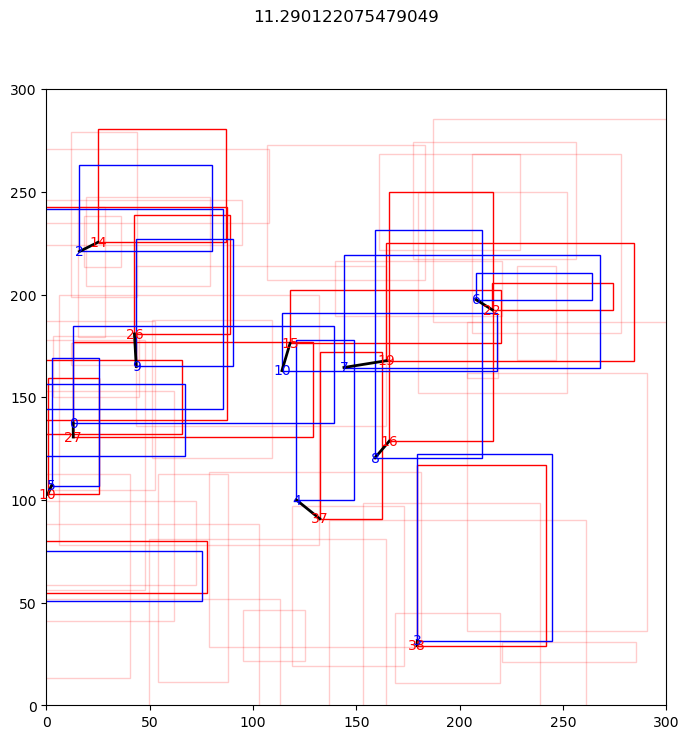

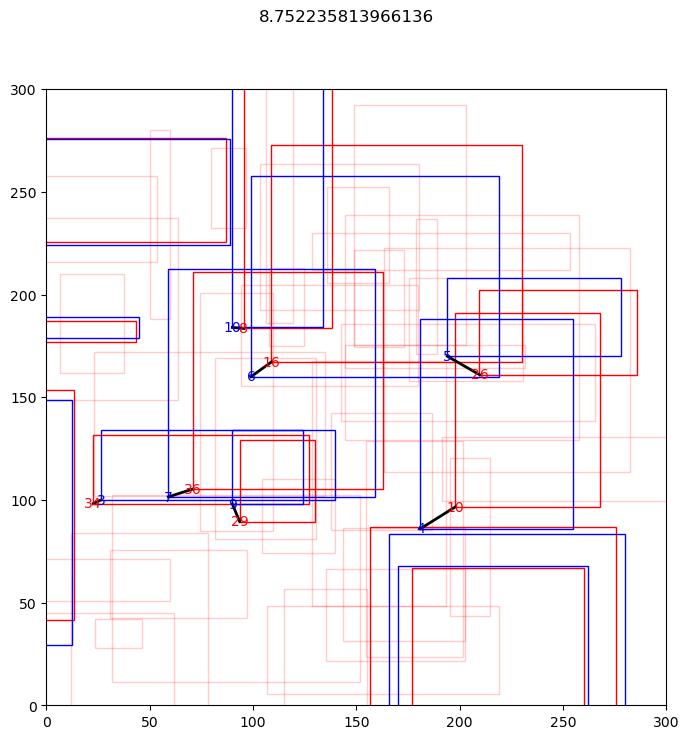

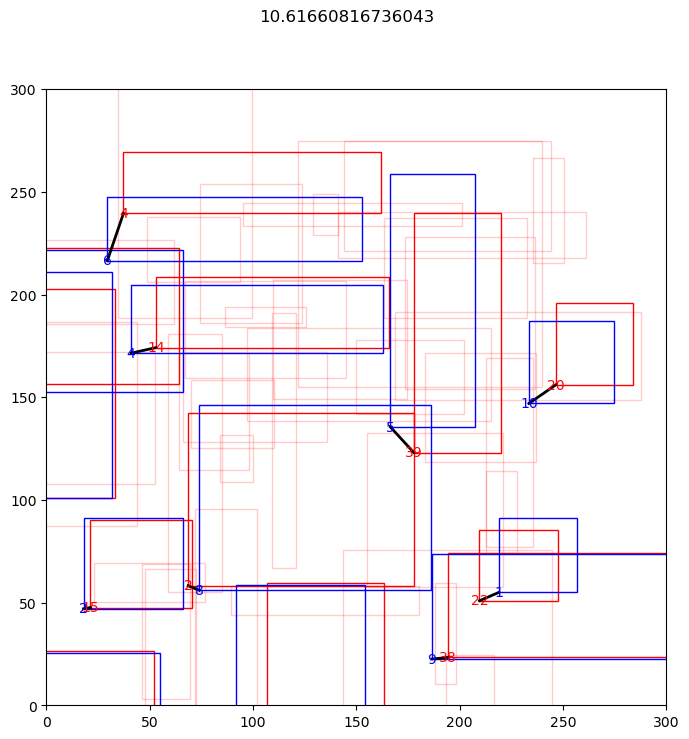

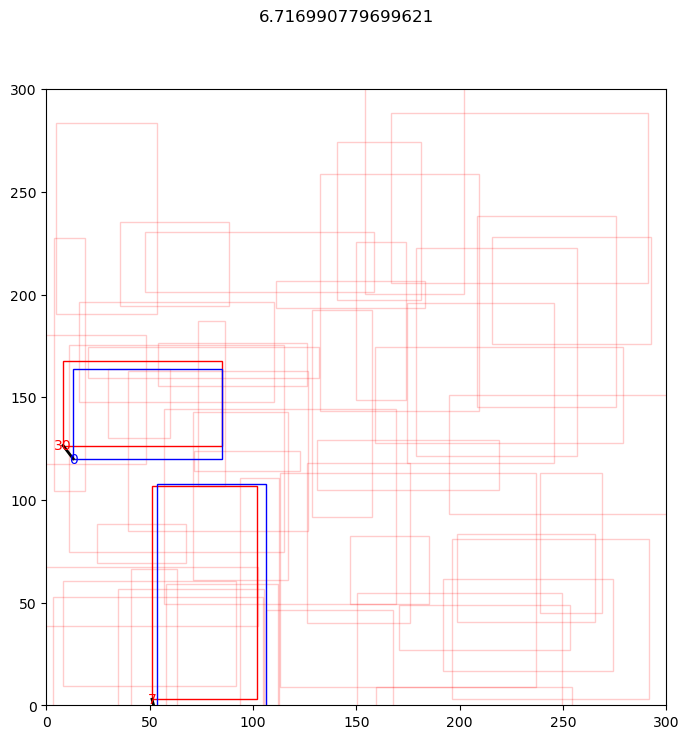

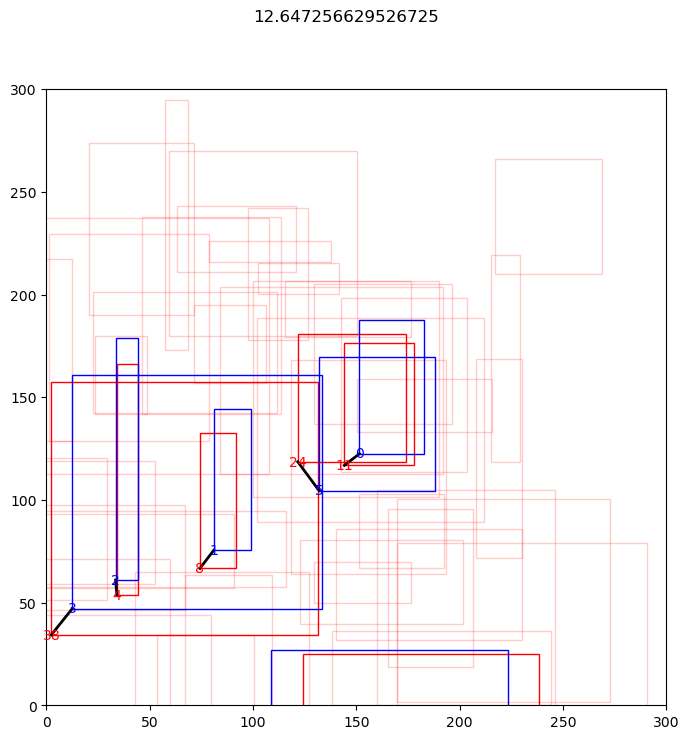

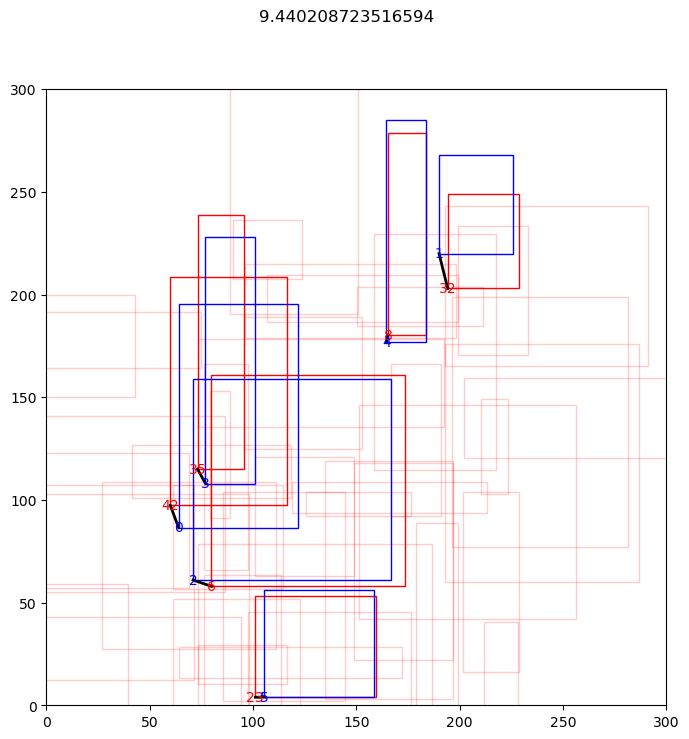

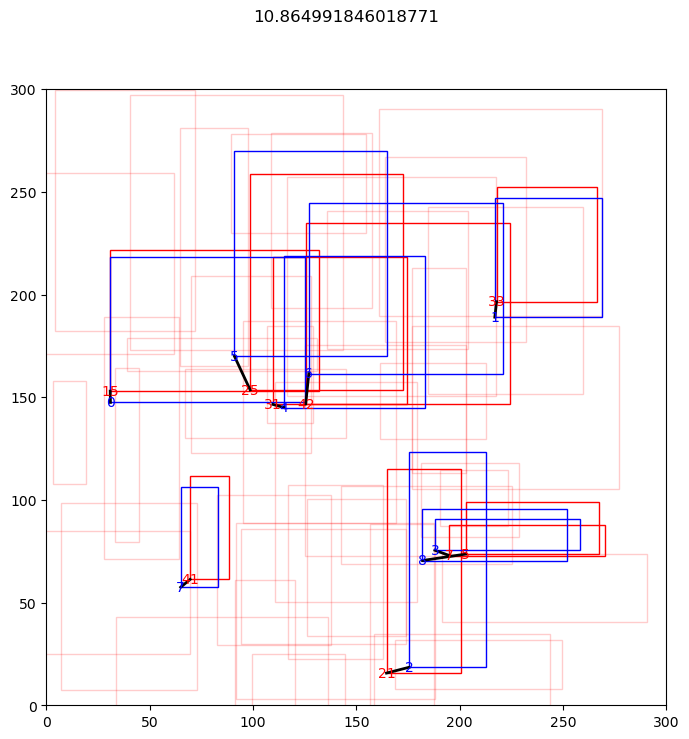

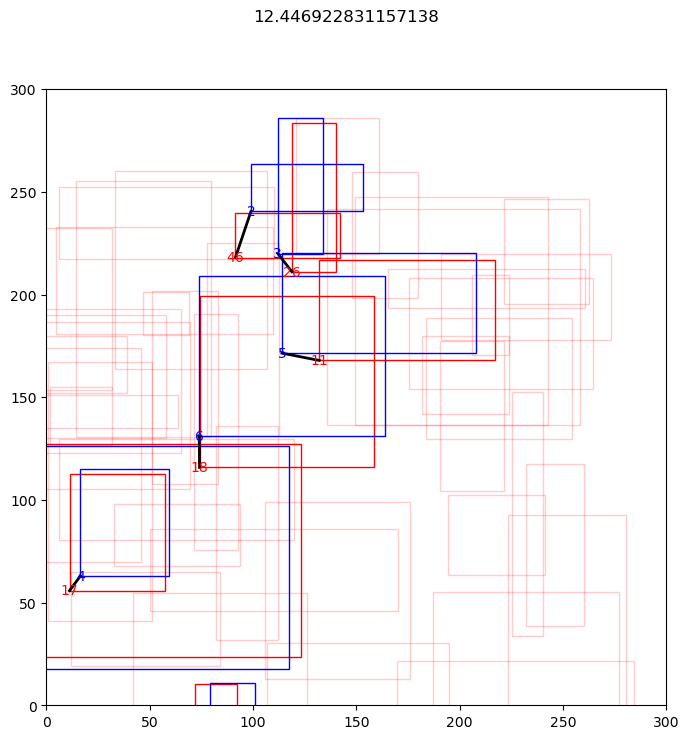

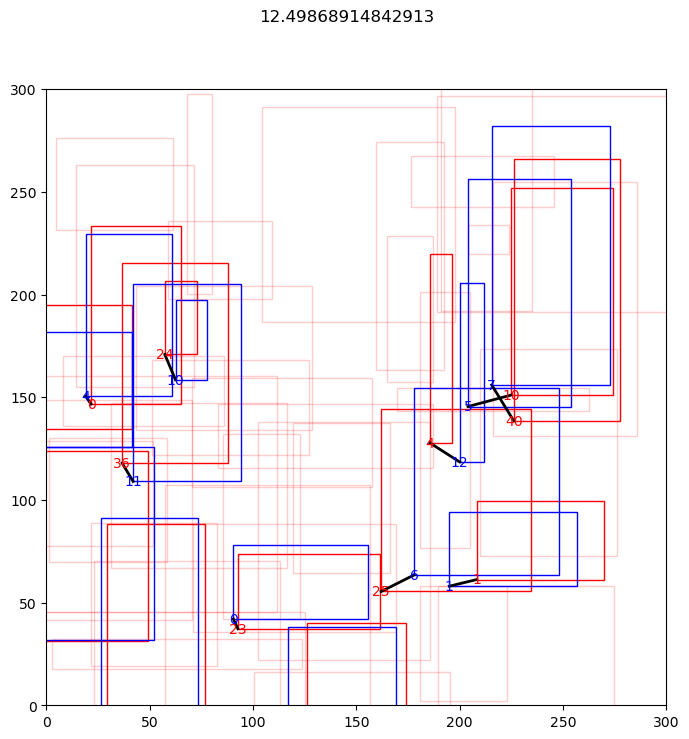

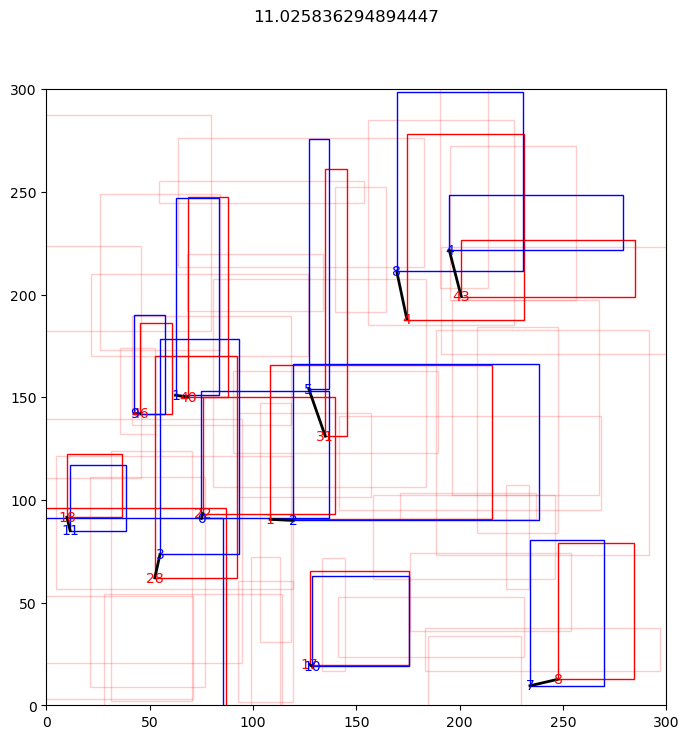

In [42]:
num_query = 50
var_rate = 0.1
for batch_idx, example_bboxes in enumerate(batch_bboxes):
    # if batch_idx != 3: continue
    rate = torch.rand(example_bboxes.shape) * var_rate * 2 - var_rate
    pred_example_bboxes = example_bboxes + example_bboxes * rate
    # pred_example_bboxes = example_bboxes

    example_bboxes_copy = example_bboxes[:]
    example_bboxes      = GIOU.yxhw_to_yxyx(example_bboxes.to     (torch.float64))
    pred_example_bboxes = GIOU.yxhw_to_yxyx(pred_example_bboxes.to(torch.float64))

    source_class_logits = torch.randn(1, num_query, 2)
    source_class_logits[0, :, 0] = 1
    source_class_logits[0, :, 1] = 0
    extra_boxes = generate_random_bbox(num_query - len(example_bboxes))
    extra_boxes = GIOU.yxhw_to_yxyx(extra_boxes)
    source_boxes = torch.cat([pred_example_bboxes[None,], extra_boxes[None,]], dim = 1)

    idx = torch.randperm(source_boxes.size(1))
    source_boxes = source_boxes[:, idx]
    target_classes = torch.zeros((1, len(example_bboxes)), dtype = int)
    target_boxes = example_bboxes[None,]

    loss = hloss(source_class_logits, target_classes, source_boxes, target_boxes)

    source_boxes_copy = source_boxes[:]
    _, row_idx, col_idx = hloss.track_var_dict['lsa'][-1]
    source_boxes = GIOU.yxyx_to_yxhw(source_boxes)
    target_boxes = GIOU.yxyx_to_yxhw(target_boxes)

    visualize_bboxes_pair(source_boxes[0], target_boxes[0], row_idx, col_idx, img_size = 300, loss = loss.item())

In [7]:
hloss.track_var_dict.keys()

dict_keys(['lsa', 'loss_cross_entropy', 'loss_box', 'loss_giou', 'loss_l1', 'flat_extend_source_boxes', 'flat_extend_target_boxes'])

In [8]:
loss_cross_entropy = hloss.track_var_dict['loss_cross_entropy'][0][1]
loss_cross_entropy.shape

torch.Size([50, 7])

In [9]:
loss_box = hloss.track_var_dict['loss_box'][0][1]
loss_box.shape

torch.Size([50, 7])

In [10]:
loss_giou = hloss.track_var_dict['loss_giou'][0][1][0]
loss_giou.shape

torch.Size([350])

In [11]:
loss_l1 = hloss.track_var_dict['loss_l1'][0][1][0]
loss_l1.shape

torch.Size([350])

In [12]:
source_boxes[0, :7]    # y, x h, w

tensor([[ 56.0000,  79.0000,  43.0000,  91.0000],
        [142.3330, 234.7133,  91.8286,  97.5152],
        [ 99.0000, 186.0000,  25.0000, 109.0000],
        [197.0000, 151.0000,  33.0000,  69.0000],
        [125.0000, 128.0000,  59.0000,  15.0000],
        [105.0000, 170.0000, 121.0000, 114.0000],
        [149.9114, 113.3394,  46.9808, 103.9149]], dtype=torch.float64)

In [13]:
GIOU.yxhw_to_yxyx(source_boxes)[0, :5]    # y, x, y, x

tensor([[ 34.5000,  33.5000,  77.5000, 124.5000],
        [ 96.4187, 185.9557, 188.2473, 283.4709],
        [ 86.5000, 131.5000, 111.5000, 240.5000],
        [180.5000, 116.5000, 213.5000, 185.5000],
        [ 95.5000, 120.5000, 154.5000, 135.5000]], dtype=torch.float64)

In [14]:
source_boxes_copy[0, :7]    # y, x, y, x

tensor([[ 34.5000,  33.5000,  77.5000, 124.5000],
        [ 96.4187, 185.9557, 188.2473, 283.4709],
        [ 86.5000, 131.5000, 111.5000, 240.5000],
        [180.5000, 116.5000, 213.5000, 185.5000],
        [ 95.5000, 120.5000, 154.5000, 135.5000],
        [ 44.5000, 113.0000, 165.5000, 227.0000],
        [126.4210,  61.3820, 173.4018, 165.2968]], dtype=torch.float64)

In [15]:
hloss.track_var_dict['flat_extend_target_boxes']

[(0,
  tensor([[ 52.0000, 123.0000, 138.0000, 247.0000],
          [230.5000,  -7.0000, 279.5000, 107.0000],
          [101.0000, 191.5000, 189.0000, 288.5000],
          ...,
          [ 55.0000, 128.0000,  91.0000, 246.0000],
          [144.5000, 186.5000, 207.5000, 221.5000],
          [128.0000,  62.5000, 174.0000, 165.5000]], dtype=torch.float64))]

In [16]:
example_bboxes_copy    # yxhw

tensor([[ 95, 185,  86, 124],
        [255,  50,  49, 114],
        [145, 240,  88,  97],
        [209, 217,  59,  28],
        [ 73, 187,  36, 118],
        [176, 204,  63,  35],
        [151, 114,  46, 103]])

In [17]:
GIOU.yxyx_to_yxhw(GIOU.yxhw_to_yxyx(example_bboxes_copy))

tensor([[ 95., 185.,  86., 124.],
        [255.,  50.,  49., 114.],
        [145., 240.,  88.,  97.],
        [209., 217.,  59.,  28.],
        [ 73., 187.,  36., 118.],
        [176., 204.,  63.,  35.],
        [151., 114.,  46., 103.]])

In [18]:
## Why loss_giou is negative?

In [19]:
loss_giou

tensor([1.3394, 1.8982, 1.6840, 1.8619, 1.3233, 1.8119, 1.6259, 1.0702, 1.7266,
        0.1552, 1.2285, 1.3710, 0.9521, 1.3431, 0.7445, 1.8260, 1.2843, 1.9240,
        0.9520, 1.7284, 1.5547, 1.4302, 1.5874, 1.4432, 1.4611, 1.8723, 1.3836,
        1.3461, 1.1021, 1.7532, 1.4508, 1.8394, 1.5928, 1.8234, 1.2777, 0.4667,
        1.6476, 1.0955, 1.3319, 0.8542, 1.1304, 1.1036, 1.2993, 1.7036, 1.3511,
        1.6563, 1.6483, 1.4865, 0.0579, 1.2212, 1.7843, 1.5344, 1.8681, 1.6590,
        1.7516, 0.9592, 1.3278, 1.7461, 0.9910, 1.0697, 1.7513, 0.0883, 1.4655,
        1.2313, 1.8648, 1.5009, 1.8924, 1.3352, 1.7737, 1.7354, 1.2841, 1.3014,
        1.2589, 1.4339, 1.4704, 1.2699, 0.7712, 1.1310, 1.7773, 1.5671, 1.6952,
        1.1694, 1.6496, 1.6054, 1.6915, 1.5934, 1.8212, 2.2084, 1.8254, 1.9643,
        1.4979, 1.4587, 1.8959, 1.6023, 1.7774, 1.6403, 1.7316, 1.7937, 1.3951,
        1.6379, 1.7638, 1.8001, 1.6248, 1.7444, 1.4784, 1.7266, 1.0428, 1.7408,
        2.0603, 1.8726, 1.8256, 1.6893, 

In [20]:
Ns, Nt = 50, 7
edge_case = torch.nonzero((loss_giou.view(Ns, Nt) < 0).to(int))
edge_case

tensor([], size=(0, 2), dtype=torch.int64)

In [21]:
box1 = source_boxes[0, 0]    # yxhw
box2 = target_boxes[0, 5]    # yxhw
box1, box2

(tensor([56., 79., 43., 91.], dtype=torch.float64),
 tensor([176., 204.,  63.,  35.], dtype=torch.float64))

56.0 79.0 43.0 91.0
176.0 204.0 63.0 35.0


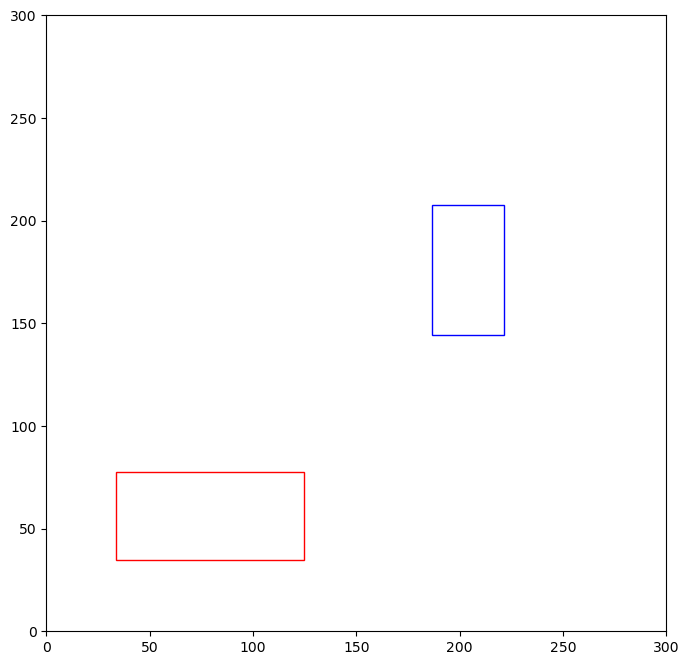

In [22]:
fig = plt.figure(figsize = (8, 8))
plt.xlim(0 ,300)
plt.ylim(0, 300)

y, x, h, w = box1
print(y.item(), x.item(), h.item(), w.item())
rect = patches.Rectangle((x - w/2, y-h/2), w, h, linewidth=1, edgecolor='red', facecolor='none')
fig.gca().add_patch(rect)

y, x, h, w = box2
print(y.item(), x.item(), h.item(), w.item())
rect = patches.Rectangle((x - w/2, y-h/2), w, h, linewidth=1, edgecolor='blue', facecolor='none')
fig.gca().add_patch(rect)

In [23]:
loss_giou.view(Ns, Nt)[0, 5]

tensor(1.8119, dtype=torch.float64)

In [24]:
input1 = GIOU.yxhw_to_yxyx(box1)[None,]
input2 = GIOU.yxhw_to_yxyx(box2)[None,]
giou, intersection_area, union_area, superbox_area = GIOU.calculate_giou(input1, input2, returns_intermediate = True)
giou, intersection_area, union_area, superbox_area

(tensor([-0.8119], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([6118.], dtype=torch.float64),
 tensor([32524.], dtype=torch.float64))

In [25]:
input1, input2

(tensor([[ 34.5000,  33.5000,  77.5000, 124.5000]], dtype=torch.float64),
 tensor([[144.5000, 186.5000, 207.5000, 221.5000]], dtype=torch.float64))

In [26]:
GIOU.get_intersection_coordinates(input1, input2)

tensor([[0., 0., 0., 0.]], dtype=torch.float64)

In [37]:
GIOU.get_superbox_coordinates(input1, input2)

tensor([[ 34.5000,  33.5000, 207.5000, 221.5000]], dtype=torch.float64)

In [38]:
GIOU.calculate_area(input1) + GIOU.calculate_area(input2)

tensor([6118.], dtype=torch.float64)

In [27]:
GIOU.calculate_area(torch.tensor([0, 0, 0, 0]))

tensor(0)

In [28]:
tt = torch.tensor([[144.5000, 186.5000,  77.5000, 124.5000]])
tt

tensor([[144.5000, 186.5000,  77.5000, 124.5000]])

In [29]:
tt

tensor([[144.5000, 186.5000,  77.5000, 124.5000]])

In [30]:
torch.all(torch.tensor([[False, True], [False, False], [True, True]]), dim = -1)

tensor([False, False,  True])

In [31]:
intersection_boxes = torch.randn(10, 4)
intersection_boxes

tensor([[-0.2266,  1.2819, -0.2478,  0.7555],
        [ 1.1254,  1.9054, -0.6261,  1.2168],
        [-0.8952,  0.3564, -0.3828, -1.7014],
        [ 1.0922, -0.7864, -1.1157,  0.5971],
        [-0.5495, -1.2917,  0.4313, -2.3931],
        [ 0.3701, -0.0029, -0.6275, -0.1461],
        [ 1.8216,  0.6720,  0.8149, -1.2956],
        [-0.7578, -1.3283,  0.3029, -0.2263],
        [-0.6808, -1.4328, -0.9188,  0.2212],
        [ 0.2385,  0.3588,  1.0614,  0.1550]])

In [32]:
min_coords = intersection_boxes[:, :2]
max_coords = intersection_boxes[:, 2:]
is_legal_box = torch.all(max_coords - min_coords < 0, dim = -1)

In [33]:
is_legal_box

tensor([ True,  True, False, False, False,  True,  True, False, False, False])

In [34]:
intersection_boxes[~is_legal_box] = 0

In [35]:
intersection_boxes

tensor([[-0.2266,  1.2819, -0.2478,  0.7555],
        [ 1.1254,  1.9054, -0.6261,  1.2168],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3701, -0.0029, -0.6275, -0.1461],
        [ 1.8216,  0.6720,  0.8149, -1.2956],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])